# London crime dataset exploration

In [1]:
# data manipulation
import numpy as np
import pandas as pd
#from datetime import date, timedelta
#from math import isnan

# get the data from Google Big Query
from google.cloud import bigquery
from pandas.io import gbq

# times series prediction
from fbprophet import Prophet

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [19]:
# the data is pretty big, so we will aggregate
# - geographically to the borrow level
# - we will restrict our analysis to 2015 and 2016 (2017 onward is incomplete or absent)

sql = '''

SELECT
    borough,
    major_category,
    minor_category,
    year,
    month,
    SUM(value) AS crime_number
    
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year IN (2015, 2016)
GROUP BY borough, major_category, minor_category, year, month
ORDER BY borough, major_category, minor_category, year, month

'''

df_london_crime = gbq.read_gbq(sql, project_id="airmet-2018-11-17", dialect='standard')
df_london_crime.head()

,borough,major_category,minor_category,year,month,crime_number
0,Barking and Dagenham,Burglary,Burglary in Other Buildings,2015,1,21
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,2015,2,28
2,Barking and Dagenham,Burglary,Burglary in Other Buildings,2015,3,40
3,Barking and Dagenham,Burglary,Burglary in Other Buildings,2015,4,42
4,Barking and Dagenham,Burglary,Burglary in Other Buildings,2015,5,39


In [20]:
# save data locally (cost and time control)
df_london_crime.to_csv('london_crime.csv')

# overview at London level and for major categories

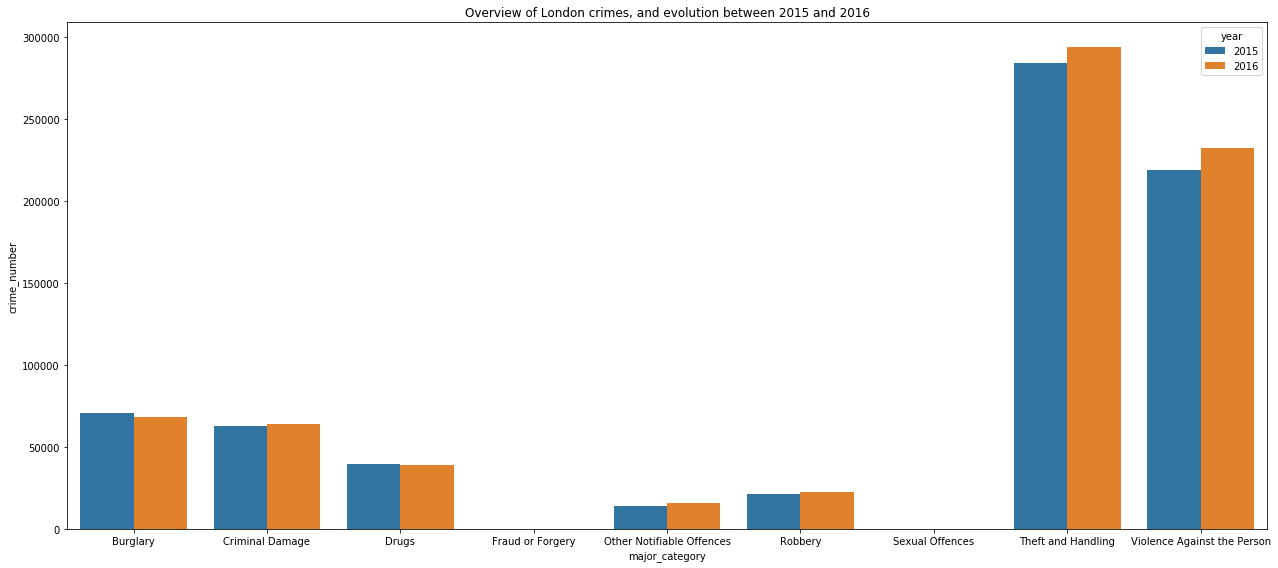

In [39]:
df_major_year = df_london_crime.groupby(['major_category', 'year'])[['crime_number']].sum().reset_index()

plt.figure(figsize=(18,8))
sns.barplot(data=df_major_year, x='major_category', y='crime_number', hue='year')
plt.title('Overview of London crimes, and evolution between 2015 and 2016')
plt.tight_layout()
plt.show()

Surprising that there are no sexual offences or fraud or forgery in the entire year overall in London!
- Perhaps the dataset is incomplete, or those crimes are reported in other categories?

Theft and handling, as well as violence against the person seem to have increased in 2016.
- Let's look at violence against the person more closely.

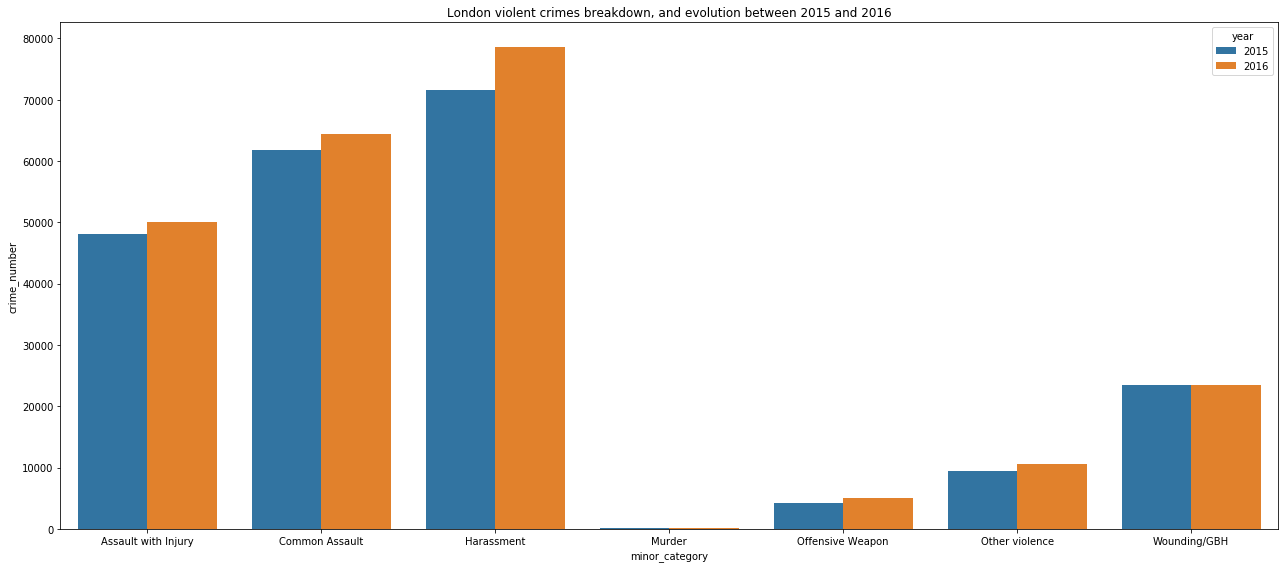

In [38]:
df_violence_year = df_london_crime[df_london_crime['major_category']=='Violence Against the Person'].groupby(
    ['minor_category', 'year'])[['crime_number']].sum().reset_index()

plt.figure(figsize=(18,8))
sns.barplot(data=df_violence_year, x='minor_category', y='crime_number', hue='year')
plt.title('London violent crimes breakdown, and evolution between 2015 and 2016')
plt.tight_layout()
plt.show()

In [27]:
df_violence_year[df_violence_year['minor_category'] == 'Murder']

,minor_category,year,crime_number
6,Murder,2015,109
7,Murder,2016,101


the murder number match broadly numbers found on wikipedia: 118 (2015) and 110 (2016)
- https://en.wikipedia.org/wiki/Crime_in_London

# seasonality

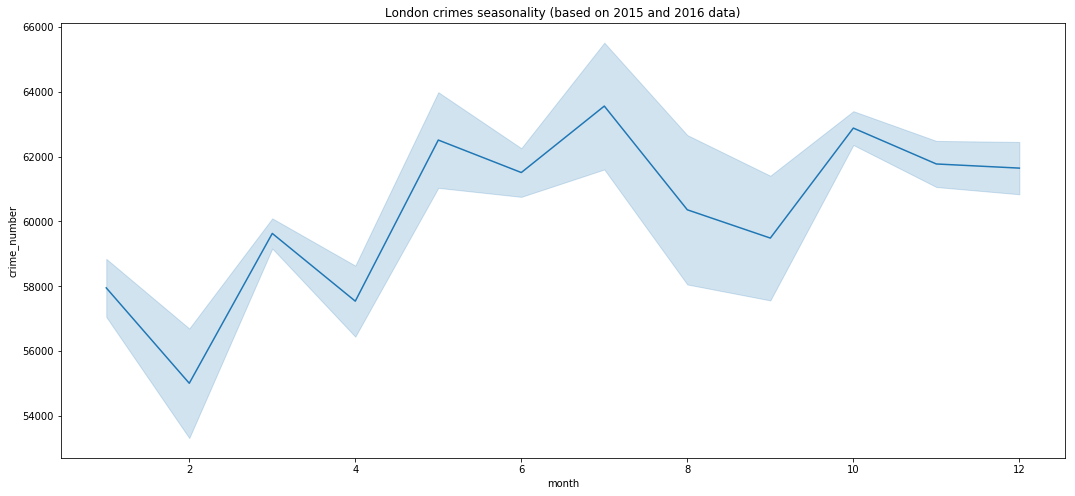

In [36]:
# agglomerate
df_seasonality = df_london_crime.groupby(['year', 'month'])[['crime_number']].sum().reset_index()

plt.figure(figsize=(18,8))
sns.lineplot(data=df_seasonality, x='month', y='crime_number')
plt.title('London crimes seasonality (based on 2015 and 2016 data)')
plt.show()

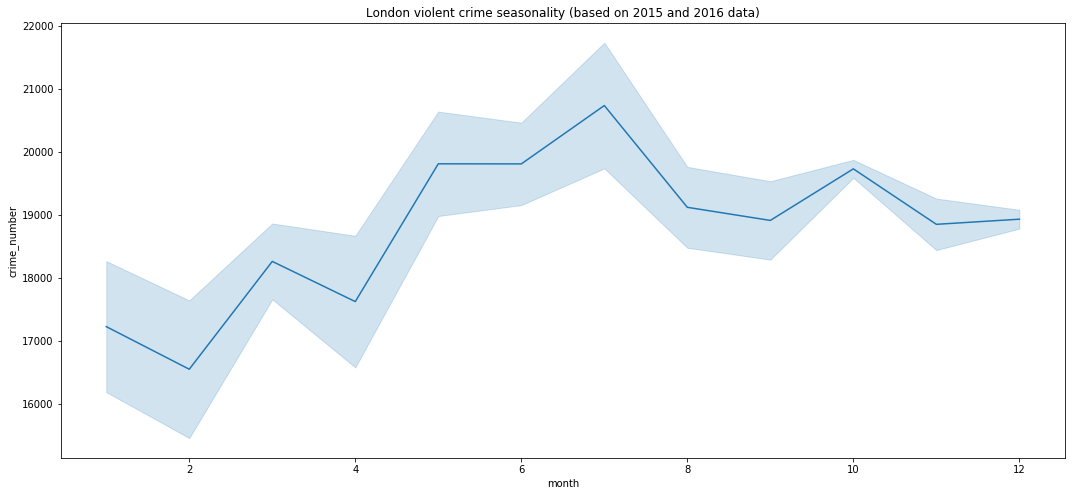

In [37]:
df_seasonality_violence = df_london_crime[df_london_crime['major_category']=='Violence Against the Person'].groupby(['year', 'month'])[['crime_number']].sum().reset_index()

plt.figure(figsize=(18,8))
sns.lineplot(data=df_seasonality_violence, x='month', y='crime_number')
plt.title('London violent crime seasonality (based on 2015 and 2016 data)')
plt.show()

There seems to be more crimes in the second half of the year - what's driving that?!

# geographical crime disparities

download map of London: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

In [49]:
import geopandas as gpd
fp = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


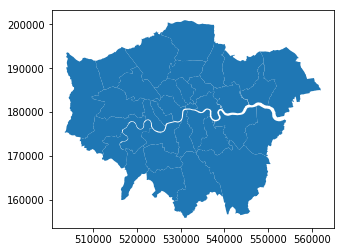

In [51]:
# map overview: this looks like London indeed
map_df.plot()

In [93]:
df_borough_2016.sort_values(by='crime_number', ascending=False).head()

,borough,crime_number
32,Westminster,48330
21,Lambeth,34071
27,Southwark,31636
24,Newham,30090
29,Tower Hamlets,29253


In [114]:
def plot_london_map(dataset, variable, title):
    merged = map_df.merge(dataset, left_on='NAME', right_on='borough', how='inner')

    vmin = dataset[variable].min()
    vmax = dataset[variable].max()
    
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(17, 10))

    # plot the actual data
    merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

    # create an annotation for the data source
    ax.annotate('Source: bigquery-public-data:london_crime',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=15, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = [] # empty array for the data range
    cbar = fig.colorbar(sm)

    plt.show()

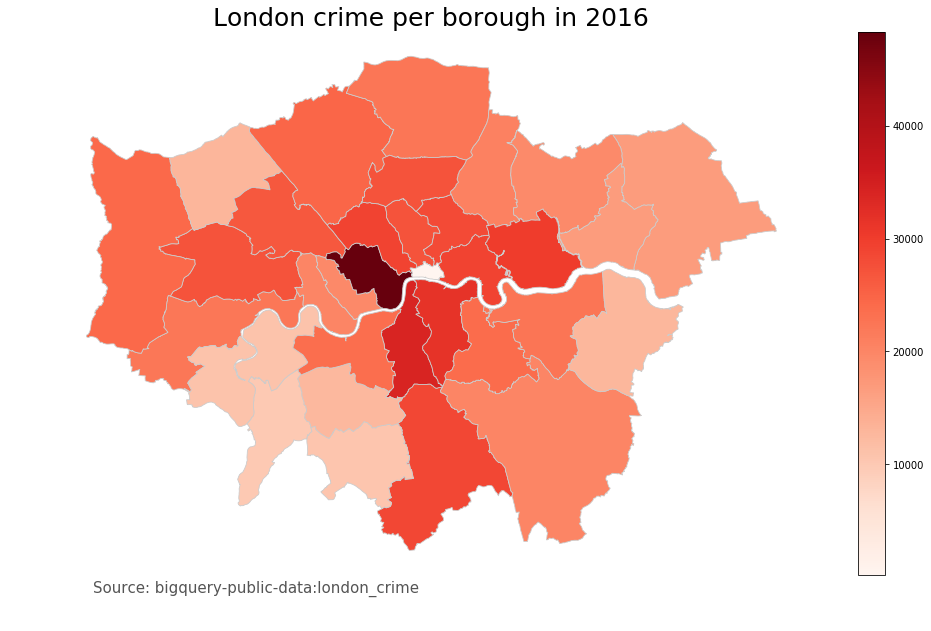

In [115]:
df_borough_2016 = df_london_crime[df_london_crime['year']==2016].groupby('borough')[['crime_number']].sum().reset_index()

plot_london_map(df_borough_2016, variable='crime_number', title='London crime per borough in 2016')

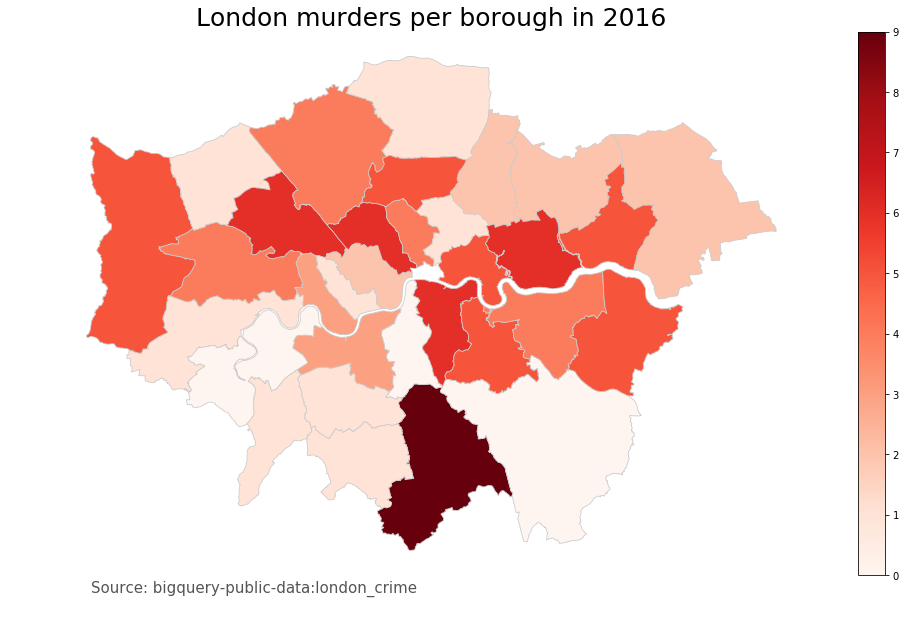

In [130]:
df_borough_2016_murder = df_london_crime[(df_london_crime['year']==2016) & (df_london_crime['minor_category']=='Murder')].groupby('borough')[['crime_number']].sum().reset_index()

plot_london_map(df_borough_2016_murder, variable='crime_number', title='London murders per borough in 2016')

# evolution of crime per borough

In [127]:
df_borough_2016 = df_london_crime[df_london_crime['year']==2016].groupby('borough')[['crime_number']].sum().reset_index()
df_borough_2015 = df_london_crime[df_london_crime['year']==2015].groupby('borough')[['crime_number']].sum().reset_index()
df_borough_2015_2016 = df_borough_2015.merge(df_borough_2016, on='borough', how='inner')
df_borough_2015_2016['crime_increase_pc'] = (df_borough_2015_2016['crime_number_y'] / df_borough_2015_2016['crime_number_x'] - 1)*100
df_borough_2015_2016.sort_values(by='crime_increase_pc', ascending=False).head()


,borough,crime_number_x,crime_number_y,crime_increase_pc
6,City of London,151,178,17.880795
13,Haringey,24626,27174,10.346788
10,Greenwich,20929,22730,8.605285
3,Brent,24883,26693,7.274043
2,Bexley,11990,12840,7.089241


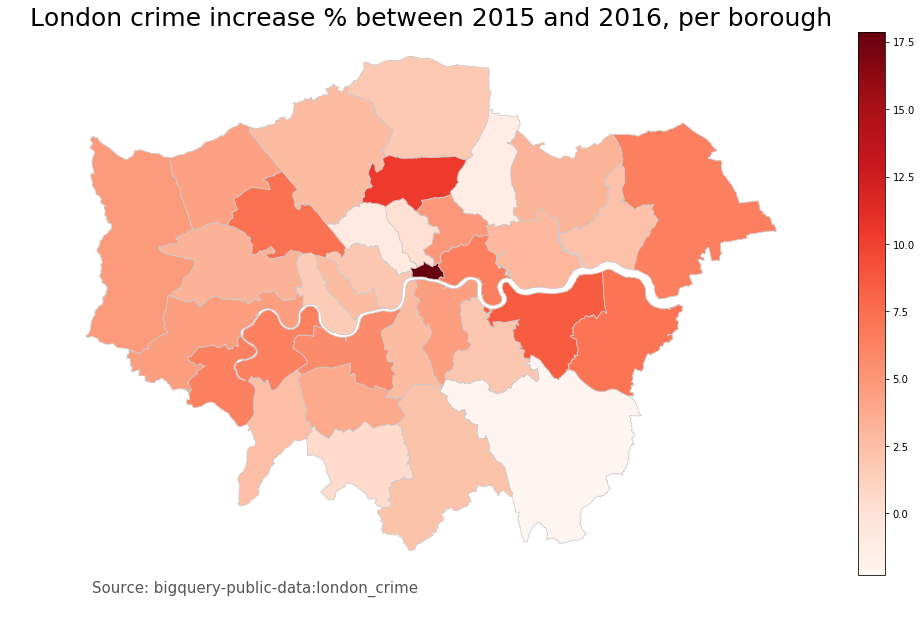

In [126]:
plot_london_map(df_borough_2015_2016, variable='crime_increase_pc', title='London crime increase % between 2015 and 2016, per borough')

# additional data to further the analysis
- population of each borough, so crime can be normalized by population (per year)
- investment in police per inhabitant, to measure police efficacy (per year
- unemployment rate, and other drivers of crime